In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.tri as tri
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

In [2]:
pklfile = '../learn/pkl_trainsets/19aug2019_opusupdate/mlecompare_not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']

### Replace nuclide concentrations with ratios

- cs137/cs133
- cs134/cs137
- cs135/cs137
- ba136/ba138
- sm150/sm149
- sm152/sm149
- eu154/eu153
- pu240/pu239
- pu241/pu239
- pu242/pu239

In [3]:
ratios = XY.loc[:, lbls].copy()

In [4]:
#cs137/cs133
ratios['cs137/cs133'] = XY['cs137'] / XY['cs133']
#cs134/cs137
ratios['cs134/cs137'] = XY['cs134'] / XY['cs137']
#cs135/cs137
ratios['cs135/cs137'] = XY['cs135'] / XY['cs137']
#ba136/ba138
ratios['ba136/ba138'] = XY['ba136'] / XY['ba138']
#sm150/sm149
ratios['sm150/sm149'] = XY['sm150'] / XY['sm149']
#sm152/sm149
ratios['sm152/sm149'] = XY['sm152'] / XY['sm149']
#eu154/eu153
ratios['eu154/eu153'] = XY['eu154'] / XY['eu153']
#pu240/pu239
ratios['pu240/pu239'] = XY['pu240'] / XY['pu239']
#pu241/pu239
ratios['pu241/pu239'] = XY['pu241'] / XY['pu239']
#pu242/pu239
ratios['pu242/pu239'] = XY['pu242'] / XY['pu239']

ratios.replace([np.inf, -np.inf], 0, inplace=True)
ratios.fillna(0, inplace = True)
#ratios

In [5]:
### filter trainXY ###
#Need to explicitly tell pandas not to worry that I'm making a copy
trainXY = ratios.loc[ratios['Burnup'] > 0].copy()
trainXY = trainXY.sample(frac=0.15)
trainXY.shape

(10972, 15)

In [6]:
def splitXY(dfXY):
    lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
    dfX = dfXY.drop(lbls, axis=1)
    r_dfY = dfXY.loc[:, lbls[0]]
    c_dfY = dfXY.loc[:, lbls[1]]
    e_dfY = dfXY.loc[:, lbls[2]]
    b_dfY = dfXY.loc[:, lbls[3]]
    o_dfY = dfXY.loc[:, lbls[4]]
    return dfX, r_dfY, c_dfY, e_dfY, b_dfY, o_dfY

X, rY, cY, eY, bY, oY = splitXY(trainXY)

In [7]:
trainXY.sample(10)

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239
17099,pwr,609.012852,2.990,937.48,vver1000,0.890071,0.001323,0.274263,0.001269,2.322785,1.114627,0.014684,0.021696,0.001065,9.696970e-06
41891,agr,2911.481358,3.090,8450.02,agr,0.773547,0.001897,0.580829,0.005188,39.268953,20.379061,0.044319,0.243363,0.061171,9.820907e-03
14331,pwr,2814.120304,3.690,6344.92,ce14x14,0.790011,0.002164,0.319511,0.003822,17.733773,8.921892,0.046635,0.125088,0.031320,2.662852e-03
3920,pwr,4064.681631,3.100,4174.53,ce14x14,0.723567,0.000449,0.331177,0.002711,11.819256,5.942115,0.025528,0.089223,0.011742,7.602757e-04
62403,phwr,2616.901677,0.711,457.12,candu37,0.783046,0.000043,0.384037,0.000911,1.344025,0.713399,0.003178,0.006795,0.000041,1.943396e-07
35893,agr,3050.798541,3.090,2602.55,agr,0.762239,0.000560,0.582706,0.002274,11.437970,5.221805,0.019957,0.084122,0.006877,2.969617e-04
59583,phwr,4888.237302,0.711,7893.96,candu19,0.680878,0.000186,0.392250,0.002546,38.270751,22.450593,0.026051,0.139021,0.009641,1.339885e-03
22049,pwr,20.488524,2.990,6058.45,vver1000,0.943227,0.020924,0.257509,0.003383,17.098592,8.805634,0.079300,0.124011,0.038556,2.171113e-03
42294,agr,1962.484593,3.090,9091.96,agr,0.821882,0.004557,0.547024,0.005493,42.197309,21.901345,0.056754,0.258200,0.078520,1.218126e-02
32019,pwr,4505.573277,3.740,6762.83,vver1000,0.711111,0.000544,0.361293,0.004140,18.008364,9.137480,0.033068,0.130902,0.027561,3.119216e-03


# ML Calculation
## Likelihoods of each observation calculated for a single comparison

In [8]:
### If random filtering: make sure sample isn't in training set ###
sim_idx = 43551
test_exist = trainXY.loc[trainXY.index == sim_idx]
test_exist

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239


In [9]:
test_sample = ratios.loc[ratios.index == sim_idx].drop(lbls, axis=1)
test_answer = ratios.loc[ratios.index == sim_idx, lbls]
test_answer
#test_sample

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
43551,agr,4903.026823,3.63,1604.81,agr


In [10]:
def ll_calc(y_sim, y_mes, std):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes, scale=std))
    return ll

def unc_calc(y_sim, y_mes, sim_unc_sq, mes_unc_sq):
    unc = ((y_sim - y_mes) / sim_unc_sq)**2 * (sim_unc_sq + mes_unc_sq)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [11]:
row_unc = 0.14
test_unc = 0.14
trainXY['LogLikelihood'] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], row_unc*row), axis=1)
#############################################################################
# pandas converts each row to a series, so using .iloc[0] on the single-row #
# dataframe that is test_sample allows the function to work properly        #
#############################################################################

In [12]:
trainXY['LLUncertainty'] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (row_unc*row)**2, (test_unc*test_sample)**2), axis=1)

In [13]:
trainXY.sample(10)

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239,LogLikelihood,LLUncertainty
53545,phwr,4328.791897,0.711,2077.13,candu19,0.703886,0.000068,0.403560,0.001245,8.359673,4.178020,0.009757,0.033015,0.000653,1.827443e-05,-3.830252e+02,1.151152e+02
58916,phwr,2781.927169,0.711,7165.21,candu19,0.777520,0.001014,0.346057,0.002375,34.712302,20.248016,0.038681,0.124877,0.010412,9.687670e-04,-1.065491e+02,2.128505e+01
39227,agr,1367.825619,3.090,5947.53,agr,0.850451,0.005174,0.526410,0.003976,27.013575,13.773756,0.051115,0.180899,0.040480,3.474653e-03,-1.132779e+02,1.739453e+01
62597,phwr,4875.008536,0.711,457.12,candu37,0.679382,0.000006,0.442635,0.000911,1.344025,0.713399,0.001930,0.006790,0.000030,1.943396e-07,-3.974183e+06,1.075440e+06
52257,phwr,1413.964781,0.711,1384.87,candu19,0.845807,0.000510,0.339888,0.001097,5.060954,2.421378,0.012602,0.021322,0.000413,5.088146e-06,-5.456590e+03,1.480419e+03
29626,pwr,611.341601,3.740,5249.81,vver1000,0.904331,0.011851,0.281201,0.003487,14.851936,7.465831,0.066292,0.107904,0.029917,1.531250e-03,-1.360700e+02,2.966231e+01
989,pwr,5719.195453,3.100,1609.97,ce14x14,0.646036,0.000035,0.371035,0.001567,4.238126,1.985237,0.007980,0.036374,0.001546,4.721464e-05,-3.146311e+01,2.683787e+01
18877,pwr,3213.290583,2.990,2273.61,vver1000,0.758717,0.000463,0.314718,0.001910,6.234815,2.983093,0.018552,0.050829,0.004053,1.249190e-04,-2.086895e+01,2.054266e+01
49146,agr,412.198332,3.630,7636.02,agr,0.906070,0.015565,0.506112,0.005033,33.965368,17.376623,0.075188,0.217690,0.074528,7.501564e-03,-1.316893e+02,1.824487e+01
70676,phwr,260.241617,0.711,7621.38,candu37,0.912473,0.010024,0.296691,0.002642,37.629021,21.765708,0.069770,0.150536,0.021381,1.647286e-03,-1.484090e+02,2.756788e+01


### Max LL: Reactor-dependent (paper presents it this way)

#### PWR

In [14]:
max_pwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'pwr'].max()
idx_pwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'pwr'].idxmax()
unc_pwr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_pwr])
print(f'Max Log Likelihood for PWRs: {max_pwr} +/- {unc_pwr}')
trainXY.loc[trainXY.index == idx_pwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for PWRs: 25.30380057368393 +/- 13.083155441964161


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
9995,pwr,5324.677315,3.69,1854.07,ce14x14


#### AGR

In [15]:
max_agr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'agr'].max()
idx_agr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'agr'].idxmax()
unc_agr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_agr])
print(f'Max Log Likelihood for AGRs: {max_agr} +/- {unc_agr}')
trainXY.loc[trainXY.index == idx_agr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for AGRs: 47.14410833595941 +/- 1.1525590167896942


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
35027,agr,4787.879817,3.09,1604.81,agr


#### PHWR

In [16]:
max_phwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'phwr'].max()
idx_phwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'phwr'].idxmax()
unc_phwr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_phwr])
print(f'Max Log Likelihood for PHWRs: {max_phwr} +/- {unc_phwr}')
trainXY.loc[trainXY.index == idx_phwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for PHWRs: 14.671433100861561 +/- 12.286534016517034


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
65100,phwr,4829.329422,0.711,2831.03,candu37


## LL wrt Burnup and Cool Time

In [17]:
min_ll = trainXY['LogLikelihood'].min()
med_ll = trainXY['LogLikelihood'].median()
mean_ll = trainXY['LogLikelihood'].mean()
max_ll = trainXY['LogLikelihood'].max()
min_ll, med_ll, mean_ll, max_ll

(-7999217.603695888, -106.8864037020432, -76294.99811618446, 47.14410833595941)

In [18]:
plotXY = trainXY.loc[trainXY['LogLikelihood'] > med_ll]
plotXY.shape, trainXY.shape

((5486, 17), (10972, 17))

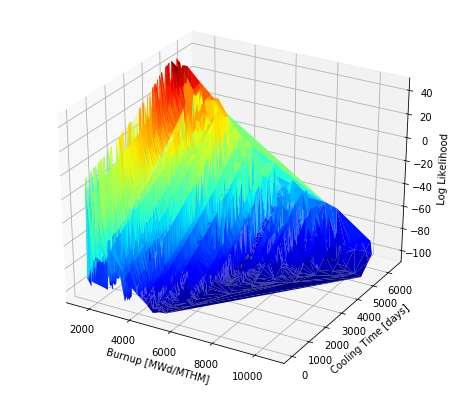

In [21]:
x = plotXY['Burnup']
y = plotXY['CoolingTime']
triang = tri.Triangulation(x, y)
z = plotXY['LogLikelihood']

fig = plt.figure(figsize=(8, 7))
ax = fig.gca(projection='3d')
ax.plot_trisurf(triang, z, linewidth=0.1, cmap='jet')#plt.cm.plasma)
#ax.scatter(x,y,z, marker='.', s=10, c='black', alpha=0.5)
#ax.view_init(elev=60, azim=-45)

ax.set_xlabel('Burnup [MWd/MTHM]')
ax.set_ylabel('Cooling Time [days]')
ax.set_zlabel('Log Likelihood')
plt.show()

# ML Estimation
## Coefficients of linear models estimated
This example is done with dependent variable = burnup

In [21]:
class NormMod(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(NormMod, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        beta = params
        yhat = np.dot(self.exog, beta)
        LL = stats.norm.logpdf(self.endog, loc=yhat)
        return -LL
    
    def fit(self, start_params=None, maxiter=100000, maxfun=100000, **kwds):
        if start_params == None:
            start_params = np.zeros(self.exog.shape[1])
            start_params[0] = np.log(self.endog.mean())
        return super(NormMod, self).fit(start_params=start_params,
                                        maxiter=maxiter, maxfun=maxfun,
                                        **kwds)
    
    def predict(self, nuc_list):
        
        return burn

In [22]:
y = bY
X = sm.add_constant(X)

/home/opotowsky/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [23]:
X.shape

(14629, 11)

In [24]:
X

,const,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239
53806,1.0,0.823392,0.000721,0.342803,0.001343,10.968661,5.628680,0.020296,0.040731,0.001372,3.431042e-05
28420,1.0,0.749728,0.000705,0.335512,0.002772,10.612981,5.221154,0.027415,0.080265,0.010929,5.689857e-04
61655,1.0,0.913999,0.013757,0.284238,0.003233,54.132357,32.032124,0.088586,0.195413,0.033621,3.776233e-03
54166,1.0,0.898284,0.002690,0.313029,0.001412,11.777379,6.193896,0.030624,0.046300,0.002115,5.029059e-05
729,1.0,0.806251,0.000714,0.297304,0.001567,4.238126,1.985237,0.017304,0.036391,0.002463,4.720175e-05
27384,1.0,0.761687,0.000536,0.327977,0.002041,5.970571,2.839640,0.019812,0.050784,0.004537,1.376314e-04
62475,1.0,0.749282,0.000023,0.401342,0.000911,1.344025,0.713399,0.002719,0.006795,0.000037,1.943396e-07
686,1.0,0.828607,0.001036,0.289283,0.001567,4.238126,1.985237,0.019040,0.036408,0.002608,4.718886e-05
66783,1.0,0.847470,0.002108,0.328358,0.001862,19.971751,11.026365,0.036554,0.084623,0.006106,2.880040e-04
53676,1.0,0.892788,0.002162,0.316157,0.001343,10.968661,5.628680,0.026941,0.040748,0.001627,3.431042e-05


In [25]:
mod = NormMod(y, X)

In [26]:
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 545458.327359
         Iterations: 1704
         Function evaluations: 2503
                               NormMod Results                                
Dep. Variable:                 Burnup   Log-Likelihood:            -7.9795e+09
Model:                        NormMod   AIC:                         1.596e+10
Method:            Maximum Likelihood   BIC:                         1.596e+10
Date:                Mon, 26 Aug 2019                                         
Time:                        12:39:45                                         
No. Observations:               14629                                         
Df Residuals:                   14618                                         
Df Model:                          10                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

/home/opotowsky/.local/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [27]:
res.params

array([ 152.78657995,  573.3246519 ,    9.28999576,  296.89667871,
       -466.11324286,  578.71779207, -664.32524069, -397.83215989,
        170.26901221, -109.53584399, -515.51328671])

In [28]:
test_sample.insert(0, 'const', 1.0)

In [29]:
burn_pred = np.sum(test_sample.iloc[0] * res.params)
burn_pred, test_answer['Burnup']

(2692.582140167781, 43552    1604.81
 Name: Burnup, dtype: float64)